# Step 3. Data training and evaluate models
Compare several machine learning models on a performance metric

Perform hyperparameter tuning on the best model to optimize it for the problem

Step 1. [Data exploration](/notebooks/forex/mark2/1_data_explore.ipynb)

Step 2. [Feature engineering](/notebooks/forex/mark2/2_feature_engineering.ipynb)

Step 3. **Data training and models evaluation**

# Import

In [70]:
from math import sqrt
from datetime import datetime
from dateutil.relativedelta import relativedelta
import talib as ta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize
from sklearn.preprocessing import Imputer, MinMaxScaler


csv_path = 'data/EURUSD_Candlestick_1_Hour_ASK_01.05.2017-18.05.2019_featured.csv'

# Load data

In [98]:
df = pd.read_csv(csv_path,
                 header=0,
                 parse_dates=True)
df.set_index('time')
print(len(df))
df.tail()

12761


,time,open,high,low,close,volume,hour,volatility,rsi,stoch_slowk,...,cci,ultosc,hour_sin,hour_cos,max_buy,max_buy_count,max_sell,max_sell_count,is_buy_profit,is_sell_profit
12756,2019-05-17 16:00:00,1.11651,1.11694,1.11640,1.11647,12190.32,16,5.4,40.01878,42.70297,...,-68.96251,52.41159,-0.86603,-0.50000,2.3,3,-9.3,4,False,False
12757,2019-05-17 17:00:00,1.11646,1.11670,1.11614,1.11650,12731.28,17,5.6,40.32716,44.04303,...,-75.39102,51.01559,-0.96593,-0.25882,2.0,1,-9.6,3,False,False
12758,2019-05-17 18:00:00,1.11649,1.11649,1.11593,1.11593,8851.12,18,5.6,36.48866,35.16583,...,-101.13716,42.50975,-1.00000,-0.00000,7.7,2,-3.9,2,False,False
12759,2019-05-17 19:00:00,1.11593,1.11670,1.11592,1.11607,17097.71,19,7.8,38.04841,27.98237,...,-78.26676,38.94281,-0.96593,0.25882,0.6,1,-5.3,1,False,False
12760,2019-05-17 20:00:00,1.11606,1.11613,1.11554,1.11582,4685.08,20,5.9,36.33250,27.23266,...,-121.55542,42.78488,-0.86603,0.50000,0.0,0,0.0,0,False,False


# Scaling Features

In [99]:
# max cci = 350
df['cci'] = df['cci'].apply(lambda x: 350 if x > 350 else x)
df['cci'] = df['cci'].apply(lambda x: -350 if x < -350 else x)

df['cci'].describe()

count    12748.000000
mean         1.338446
std        115.346233
min       -350.000000
25%        -83.736030
50%          4.264375
75%         87.054832
max        350.000000
Name: cci, dtype: float64

In [100]:
df['rsi'] = df['rsi'] / 100
df['stoch_slowk'] = df['stoch_slowk'] / 100
df['stoch_slowd'] = df['stoch_slowd'] / 100
df['stochrsi_fastk'] = df['stochrsi_fastk'] / 100
df['stochrsi_fastd'] = df['stochrsi_fastd'] / 100
df['adx'] = df['adx'] / 100
df['williams_r'] = (df['williams_r'] + 100) / 100
df['cci'] = df['cci'] + 350
df['cci'] = df['cci'] / 700
df['ultosc'] = df['ultosc'] / 100

In [101]:
for x in [
        'rsi', 'stoch_slowk', 'stoch_slowd', 'stochrsi_fastk',
        'stochrsi_fastd', 'adx', 'williams_r', 'cci', 'ultosc'
]:
    print(x,df[x].min(), df[x].max())

rsi 0.12690590000000002 0.9205115
stoch_slowk 0.0264704 0.9862359
stoch_slowd 0.033708999999999996 0.9791138
stochrsi_fastk 0.0 1.0
stochrsi_fastd -0.0 1.0
adx 0.0665423 0.7627457
williams_r 0.0 1.0
cci 0.0 1.0
ultosc 0.1643647 0.8514667


# Traning data and test

In [119]:
df.columns

Index(['time', 'open', 'high', 'low', 'close', 'volume', 'hour', 'volatility',
       'rsi', 'stoch_slowk', 'stoch_slowd', 'stochrsi_fastk', 'stochrsi_fastd',
       'adx', 'williams_r', 'cci', 'ultosc', 'hour_sin', 'hour_cos', 'max_buy',
       'max_buy_count', 'max_sell', 'max_sell_count', 'is_buy_profit',
       'is_sell_profit'],
      dtype='object')

In [136]:
df = df.dropna()
start_hour = 8
end_hour = 16

test_df = df[(df['time'] > '2019-01-22 14:00:00') & (df['hour'] > start_hour)
             & (df['hour'] < end_hour)]
buy_test_y = np.array(test_df['max_buy']).reshape((-1, ))
sell_test_y = np.array(test_df['max_sell']).reshape((-1, ))
# test_df.drop([
#     'time', 'open', 'high', 'low', 'close', 'volume', 'hour', 'volatility',
#     'stochrsi_fastk', 'hour_sin', 'hour_cos', 'max_buy', 'max_buy_count',
#     'max_sell', 'max_sell_count', 'is_buy_profit', 'is_sell_profit'
# ],
#              axis=1,
#              inplace=True)

test_x = test_df.as_matrix(columns=[
    'rsi', 'stoch_slowk', 'stoch_slowd', 'stochrsi_fastd', 'adx', 'williams_r',
    'cci', 'ultosc'
])
print(len(test_x), len(buy_test_y), len(sell_test_y))

test_df.head()

582 582 582


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


,time,open,high,low,close,volume,hour,volatility,rsi,stoch_slowk,...,cci,ultosc,hour_sin,hour_cos,max_buy,max_buy_count,max_sell,max_sell_count,is_buy_profit,is_sell_profit
10762,2019-01-22 15:00:00,1.13556,1.13649,1.13546,1.13565,29795.2891,15,10.3,0.440455,0.477547,...,0.510746,0.473586,-0.70711,-0.70711,17.6,12,-4.4,3,False,False
10780,2019-01-23 09:00:00,1.13623,1.13648,1.13537,1.13560,20990.8594,9,11.1,0.420349,0.632192,...,0.326274,0.552093,0.70711,-0.70711,38.7,12,-5.2,3,False,False
10781,2019-01-23 10:00:00,1.13561,1.13596,1.13512,1.13577,20105.0898,10,8.4,0.440424,0.539686,...,0.264065,0.574536,0.50000,-0.86603,37.0,12,-6.9,2,False,False
10782,2019-01-23 11:00:00,1.13579,1.13676,1.13577,1.13654,19036.0898,11,9.9,0.521294,0.489248,...,0.488092,0.583990,0.25882,-0.96593,29.3,12,-14.6,4,False,False
10783,2019-01-23 12:00:00,1.13654,1.13699,1.13618,1.13660,18040.6602,12,8.1,0.527030,0.446316,...,0.565936,0.554779,0.00000,-1.00000,28.7,12,-15.2,3,False,False


In [137]:
train_df = df[(df['time'] <= '2019-01-22 14:00:00') & (df['hour'] > start_hour)
              & (df['hour'] < end_hour)]
buy_train_y = np.array(train_df['max_buy']).reshape((-1, ))
sell_train_y = np.array(train_df['max_sell']).reshape((-1, ))
train_x = train_df.as_matrix(columns=[
    'rsi', 'stoch_slowk', 'stoch_slowd', 'stochrsi_fastd', 'adx', 'williams_r',
    'cci', 'ultosc'
])
print(len(train_x),len(buy_train_y), len(sell_train_y))
train_df.head()

3128 3128 3128


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


,time,open,high,low,close,volume,hour,volatility,rsi,stoch_slowk,...,cci,ultosc,hour_sin,hour_cos,max_buy,max_buy_count,max_sell,max_sell_count,is_buy_profit,is_sell_profit
33,2017-05-02 09:00:00,1.09154,1.09216,1.09089,1.09184,7632.3198,9,12.7,0.589489,0.593890,...,0.622940,0.536941,0.70711,-0.70711,15.2,6,-30.0,9,False,False
34,2017-05-02 10:00:00,1.09184,1.09196,1.09093,1.09170,5631.5200,10,10.3,0.574812,0.562226,...,0.589939,0.556211,0.50000,-0.86603,16.6,8,-28.6,8,False,False
35,2017-05-02 11:00:00,1.09170,1.09183,1.09049,1.09053,6788.1099,11,13.4,0.469591,0.439104,...,0.413558,0.488544,0.25882,-0.96593,31.1,12,-16.9,6,False,False
36,2017-05-02 12:00:00,1.09055,1.09161,1.09044,1.09078,8840.8701,12,11.7,0.491030,0.345547,...,0.401878,0.445307,0.00000,-1.00000,29.2,12,-19.4,5,False,False
37,2017-05-02 13:00:00,1.09080,1.09133,1.09047,1.09094,8979.9902,13,8.6,0.504825,0.360958,...,0.391178,0.498783,-0.25882,-0.96593,27.7,12,-21.0,4,False,False


# Mean Absolute Error as criteria function

In [141]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model,xx,yy,test_xx,test_yy):
    
    # Train the model
    model.fit(xx, yy)
    
    # Make predictions and evalute
    model_pred = model.predict(test_xx)
    model_mae = mae(test_yy, model_pred)
    
    # Return the performance metric
    return model_mae

# Regression Models to Evaluate

In [143]:
# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# BUY direction

In [145]:
# Linear regression

lr = LinearRegression()
lr_mae = fit_and_evaluate(lr, train_x, buy_train_y, test_x, buy_test_y)

print('Linear Regression Performance on the test set: MAE = %0.4f' % lr_mae)

Linear Regression Performance on the test set: MAE = 17.3433


In [146]:
# SVM

svm = SVR(C = 1000, gamma = 0.1)
svm_mae = fit_and_evaluate(svm, train_x, buy_train_y, test_x, buy_test_y)

print('Support Vector Machine Regression Performance on the test set: MAE = %0.4f' % svm_mae)

Support Vector Machine Regression Performance on the test set: MAE = 14.4866


In [147]:
# Random forest

random_forest = RandomForestRegressor(random_state=60)
random_forest_mae = fit_and_evaluate(random_forest, train_x, buy_train_y, test_x, buy_test_y)

print('Random Forest Regression Performance on the test set: MAE = %0.4f' % random_forest_mae)

/opt/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest Regression Performance on the test set: MAE = 18.3285


In [148]:
# Gradien boosted

gradient_boosted = GradientBoostingRegressor(random_state=60)
gradient_boosted_mae = fit_and_evaluate(gradient_boosted, train_x, buy_train_y, test_x, buy_test_y)

print('Gradient Boosted Regression Performance on the test set: MAE = %0.4f' % gradient_boosted_mae)

Gradient Boosted Regression Performance on the test set: MAE = 17.8221


In [149]:
# KNN

knn = KNeighborsRegressor(n_neighbors=10)
knn_mae = fit_and_evaluate(knn, train_x, buy_train_y, test_x, buy_test_y)

print('K-Nearest Neighbors Regression Performance on the test set: MAE = %0.4f' % knn_mae)

K-Nearest Neighbors Regression Performance on the test set: MAE = 17.9171


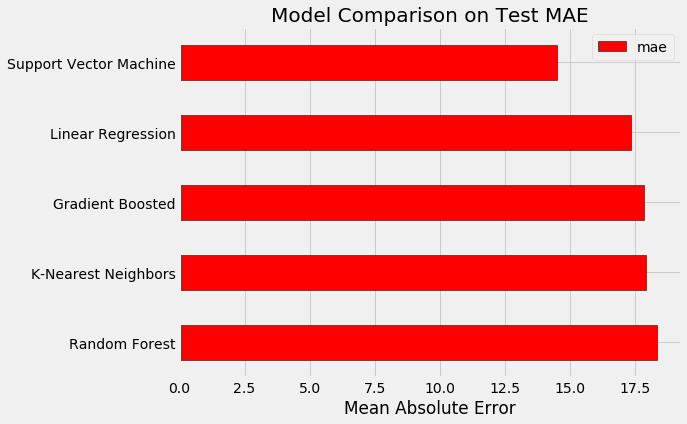

In [150]:
plt.style.use('fivethirtyeight')
figsize(8, 6)

# Dataframe to hold the results
model_comparison = pd.DataFrame({'model': ['Linear Regression', 'Support Vector Machine',
                                           'Random Forest', 'Gradient Boosted',
                                            'K-Nearest Neighbors'],
                                 'mae': [lr_mae, svm_mae, random_forest_mae, 
                                         gradient_boosted_mae, knn_mae]})

# Horizontal bar chart of test mae
model_comparison.sort_values('mae', ascending = False).plot(x = 'model', y = 'mae', kind = 'barh',
                                                           color = 'red', edgecolor = 'black')

# Plot formatting
plt.ylabel(''); plt.yticks(size = 14); plt.xlabel('Mean Absolute Error'); plt.xticks(size = 14)
plt.title('Model Comparison on Test MAE', size = 20);

# Model Optimization

SVM is the best one, will select SVM to do Optimization and Hyperparameter Tuning.

In [16]:
print(y_test.shape)
print(X_test.shape)

(13935,)
(13935, 4)


In [18]:
print(y_test.shape)

(13935,)


In [ ]:
# we explicitly generate the outer_cv decorator so we can use it twice
outer_cv = optunity.cross_validated(x=X, y=y, num_folds=3, num_iter=2)

# define objective function for tuning
@optunity.cross_validated(x=X, y=y, num_iter=2, num_folds=5)
def tune_cv(x_train, y_train, x_t, y_t, C, degree, coef0):
    model = sklearn.svm.SVR(C=C, degree=degree, coef0=coef0, kernel='poly').fit(x_train, y_train)
    predictions = model.predict(x_t)
    return optunity.metrics.mse(y_t, predictions)


    
def compute_mse_standard(x_train, y_train, x_test, y_test):
    """Computes MSE of an SVR with RBF kernel and default hyperparameters.
    """
    model = sklearn.svm.SVR().fit(x_train, y_train)
    predictions = model.predict(x_test)
    return optunity.metrics.mse(y_test, predictions)

# wrap with outer cross-validation
compute_mse_with_cv = outer_cv(compute_mse_standard)
compute_mse_with_cv()

In [ ]:
import optunity
import optunity.metrics
import sklearn.svm

# score function: twice iterated 10-fold cross-validated accuracy
@optunity.cross_validated(x=X, y=y, num_folds=10, num_iter=2)
def svm_auc(x_train, y_train, x_test, y_test, logC, logGamma):
    model = SVR(C=10 ** logC, gamma=10 ** logGamma).fit(x_train, y_train)
    predictions = model.predict(x_test)
    return mae(y_test, predictions)

# perform tuning
hps, _, _ = optunity.maximize(svm_auc, num_evals=10, logC=[-5, 2], logGamma=[-5, 1])
print(hps)

In [52]:
# manually grid search 
from itertools import product
combination = list(product(*[range(-3, 4), range(-4, 3)]))
result = []
for a, b in combination:
    svm = SVR(C=10**a, gamma=10**b)
    svm_mae = fit_and_evaluate(svm)
    result.append((10**a, 10**b, svm_mae))
    print(f'C={10 ** a}, gamma={10 ** b}  = {svm_mae}')

C=0.001, gamma=0.0001  = 3.7637078983794177
C=0.001, gamma=0.001  = 3.7636835461338305
C=0.001, gamma=0.01  = 3.763375913798129
C=0.001, gamma=0.1  = 3.7601455839443436
C=0.001, gamma=1  = 3.740820001029104
C=0.001, gamma=10  = 3.7131975881375197
C=0.01, gamma=0.0001  = 3.7636835436299436
C=0.01, gamma=0.001  = 3.7633845525066283
C=0.01, gamma=0.01  = 3.7601029219695508
C=0.01, gamma=0.1  = 3.738815357878329
C=0.01, gamma=1  = 3.695629439188367
C=0.01, gamma=10  = 3.6947023440239772
C=0.01, gamma=100  = 3.713421024452286
C=0.1, gamma=0.0001  = 3.7633726919599586
C=0.1, gamma=0.001  = 3.7600993550175548
C=0.1, gamma=0.01  = 3.7385843163792516
C=0.1, gamma=0.1  = 3.695796937757105
C=0.1, gamma=1  = 3.6903271645344176
C=0.1, gamma=10  = 3.6969897527009774
C=0.1, gamma=100  = 3.7088747548728236
C=1, gamma=0.0001  = 3.7600988760544656
C=1, gamma=0.001  = 3.738556286076489
C=1, gamma=0.01  = 3.695856933699899
C=1, gamma=0.1  = 3.69225265007057
C=1, gamma=1  = 3.6916386095096048
C=1, gamma=10

The best one is 

C=0.1, gamma=1, 3.6903271645344176

In [29]:
# train model on the full training set with tuned hyperparameters
optimal_model = SVR(C=0.1, gamma=1).fit(X, y)
model_pred = optimal_model.predict(X_test)
model_mae = mae(y_test, model_pred)
print(model_mae)

3.6903271645344176
